In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/IPMI-2023


In [2]:
import sys, os
import numpy as np
import pandas as pd

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../param_search')
%aimport param_search
ps = param_search

Using backend: pytorch



# IPMI 2023 patient experiment

In [3]:
%pwd

'/ocean/projects/asc170022p/mtragoza/mre-pinn/IPMI-2023'

In [4]:
# define the job template and name format

template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH --time=48:00:00
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
#SBATCH --mail-type=all

hostname
pwd
source activate MRE-PINN

python ../../../train.py \\
    --xarray_dir {xarray_dir} \\
    --example_id {example_id} \\
    --frequency {frequency} \\
    --omega {omega} \\
    --polar_input {polar_input} \\
    --pde_name {pde_name} \\
    --pde_warmup_iters 10000 \\
    --pde_step_iters 5000 \\
    --pde_step_factor 10 \\
    --pde_init_weight {pde_init_weight} \\
    --pde_loss_weight {pde_loss_weight} \\
    --save_prefix {job_name}    
'''
name = 'train_{data_name}_{example_id}_{pde_name}'

# define the parameter space

patient_space = ps.ParamSpace(
    data_name='patient',
    xarray_dir='../../../data/NAFLD/v3',
    example_id=['0006', '0020', '0024', '0029', '0043', '0047', '0126', '0135', '0155', '0164', '0172', '0173', '0210', '0213', '0219', '0222', '0234', '0235', '0291', '0344', '0378', '0384', '0395', '0401', '0415', '0457', '0461', '0491', '0492', '0496', '0509', '0510', '0516', '0525', '0564', '0604', '0612', '0615', '0628', '0639', '0648', '0650', '0653', '0655', '0659', '0693', '0704', '0717', '0727', '0734', '0737', '0740', '0747', '0748', '0898', '0900', '0929', '0931', '0932', '0940', '0954', '0964', '0965', '0979', '0989', '0995', '1028', '1033', '1039', '1045', '1075', '1076', '1077', '1083', '1103', '1106', '1108', '1110', '1119', '1121', '1123', '1134', '1144', '1149', '1205', '1207', '1215', '1217', '1230', '1261', '1271', '1296', '1303', '1311', '1329', '1337', '1341', '1343', '1344', '1382', '1395', '1400', '1404', '1417', '1426', '1427', '1433', '1435', '1448', '1453', '1456', '1464', '1671', '1679', '1694', '1699', '1706', '1712', '1714', '1715', '1720', '1722', '1727', '1736', '1748', '1785', '1786', '1790', '1791', '1793', '1795', '1798', '1806', '1807', '1819', '1829', '1839', '1843', '1851', '1853', '1896', '1899', '1903', '1917', '1935', '1940', '1948', '1967', '1979', '1980', '2001', '2007', '2029', '2034', '2046'],
    frequency=40,
    omega=60,
    pde_name=['hetero'],
    pde_init_weight=1e-18,
    pde_loss_weight=1e-16,
    polar_input=1,
)
patient_space2 = ps.ParamSpace(
    data_name='patient',
    xarray_dir='../../../data/NAFLD/v3',
    example_id=['0006', '0020', '0024', '0029', '0043', '0047', '0126', '0135', '0155', '0164', '0172', '0173', '0210', '0213', '0219', '0222', '0234', '0235', '0291', '0344', '0378', '0384', '0395', '0401', '0415', '0457', '0461', '0491', '0492', '0496', '0509', '0510', '0516', '0525', '0564', '0604', '0612', '0615', '0628', '0639', '0648', '0650', '0653', '0655', '0659', '0693', '0704', '0717', '0727', '0734', '0737', '0740', '0747', '0748', '0898', '0900', '0929', '0931', '0932', '0940', '0954', '0964', '0965', '0979', '0989', '0995', '1028', '1033', '1039', '1045', '1075', '1076', '1077', '1083', '1103', '1106', '1108', '1110', '1119', '1121', '1123', '1134', '1144', '1149', '1205', '1207', '1215', '1217', '1230', '1261', '1271', '1296', '1303', '1311', '1329', '1337', '1341', '1343', '1344', '1382', '1395', '1400', '1404', '1417', '1426', '1427', '1433', '1435', '1448', '1453', '1456', '1464', '1671', '1679', '1694', '1699', '1706', '1712', '1714', '1715', '1720', '1722', '1727', '1736', '1748', '1785', '1786', '1790', '1791', '1793', '1795', '1798', '1806', '1807', '1819', '1829', '1839', '1843', '1851', '1853', '1896', '1899', '1903', '1917', '1935', '1940', '1948', '1967', '1979', '1980', '2001', '2007', '2029', '2034', '2046'],
    frequency=40,
    omega=60,
    pde_name=['helmholtz', 'hetero2'],
    pde_init_weight=1e-18,
    pde_loss_weight=1e-16,
    polar_input=1,
)

param_space = patient_space2
len(param_space)

310

In [52]:
%autoreload
expt_name = '2022-11-23_patient_init'
init_jobs = pd.read_csv(f'{expt_name}.jobs')

#jobs = ps.submit(template, name, param_space, work_dir=expt_name, verbose=True)
#jobs.to_csv(f'{expt_name}.jobs')

expt_name = '2022-11-26_patient_hetero2'
hetero2_jobs = pd.read_csv(f'{expt_name}.jobs')

jobs = pd.concat([hetero2_jobs, init_jobs])

In [38]:
status_cols = ['job_name', 'job_state', 'node_id', 'runtime', 'stdout', 'stderr']
status = ps.status(jobs)
status[status_cols]

,job_name,job_state,node_id,runtime,stdout,stderr
job_id,,,,,,
13284149,train_patient_0006_hetero,NaN,NaN,NaN,v005.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13284150,train_patient_0020_hetero,NaN,NaN,NaN,v005.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13284151,train_patient_0024_hetero,NaN,NaN,NaN,v003.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13284152,train_patient_0029_hetero,NaN,NaN,NaN,v008.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13284153,train_patient_0043_hetero,NaN,NaN,NaN,v008.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
...,...,...,...,...,...,...
13296204,train_patient_2029_hetero2,NaN,NaN,NaN,v029.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\nTraceback (most rece...
13296205,train_patient_2034_helmholtz,NaN,NaN,NaN,v025.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13296206,train_patient_2034_hetero2,NaN,NaN,NaN,v025.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\nTraceback (most rece...


In [8]:
errors = status[status.stderr != 'Using backend: pytorch\n\n']
errors

,index,Unnamed: 0,data_name,xarray_dir,example_id,frequency,omega,pde_name,pde_init_weight,pde_loss_weight,polar_input,job_name,partition,job_state,node_id,runtime,work_dir,array_idx,stdout,stderr
job_id,,,,,,,,,,,,,,,,,,,,
13284160,11,11,patient,../../../data/NAFLD/v3,173,40,60,hetero,1.000000e-18,1.000000e-16,1,train_patient_0173_hetero,GPU-shared,NaN,NaN,NaN,/ocean/projects/asc170022p/mtragoza/mre-pinn/I...,NaN,v013.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\nTraceback (most rece...
13284207,58,58,patient,../../../data/NAFLD/v3,932,40,60,hetero,1.000000e-18,1.000000e-16,1,train_patient_0932_hetero,GPU-shared,NaN,NaN,NaN,/ocean/projects/asc170022p/mtragoza/mre-pinn/I...,NaN,v007.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\nTraceback (most rece...
13284208,59,59,patient,../../../data/NAFLD/v3,940,40,60,hetero,1.000000e-18,1.000000e-16,1,train_patient_0940_hetero,GPU-shared,NaN,NaN,NaN,/ocean/projects/asc170022p/mtragoza/mre-pinn/I...,NaN,v007.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\nTraceback (most rece...
13284213,64,64,patient,../../../data/NAFLD/v3,989,40,60,hetero,1.000000e-18,1.000000e-16,1,train_patient_0989_hetero,GPU-shared,NaN,NaN,NaN,/ocean/projects/asc170022p/mtragoza/mre-pinn/I...,NaN,v028.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\nTraceback (most rece...
13284257,102,102,patient,../../../data/NAFLD/v3,1404,40,60,hetero,1.000000e-18,1.000000e-16,1,train_patient_1404_hetero,GPU-shared,NaN,NaN,NaN,/ocean/projects/asc170022p/mtragoza/mre-pinn/I...,NaN,v025.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\nTraceback (most rece...
13284268,113,113,patient,../../../data/NAFLD/v3,1679,40,60,hetero,1.000000e-18,1.000000e-16,1,train_patient_1679_hetero,GPU-shared,NaN,NaN,NaN,/ocean/projects/asc170022p/mtragoza/mre-pinn/I...,NaN,v021.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\nTraceback (most rece...
13284270,115,115,patient,../../../data/NAFLD/v3,1699,40,60,hetero,1.000000e-18,1.000000e-16,1,train_patient_1699_hetero,GPU-shared,NaN,NaN,NaN,/ocean/projects/asc170022p/mtragoza/mre-pinn/I...,NaN,v025.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\nTraceback (most rece...
13284292,137,137,patient,../../../data/NAFLD/v3,1843,40,60,hetero,1.000000e-18,1.000000e-16,1,train_patient_1843_hetero,GPU-shared,NaN,NaN,NaN,/ocean/projects/asc170022p/mtragoza/mre-pinn/I...,NaN,v032.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\nWARNING:py.warnings:...
13284293,138,138,patient,../../../data/NAFLD/v3,1851,40,60,hetero,1.000000e-18,1.000000e-16,1,train_patient_1851_hetero,GPU-shared,NaN,NaN,NaN,/ocean/projects/asc170022p/mtragoza/mre-pinn/I...,NaN,NaN,NaN


In [53]:
metrics = ps.metrics(jobs)

# did all models train to 100k iterations?
#assert (metrics.groupby('job_name')['iteration'].max() == 100e3).all()

# get the final test evaluations
metrics = metrics[metrics.iteration == 100e3]

param_cols = ['pde_name', 'example_id'] # experimental parameters
index_cols = ['variable_name', 'spatial_frequency_bin', 'spatial_region'] # metric identifiers
metric_cols = ['MSAV', 'PSD', 'MAV'] # metric values

metrics = metrics.groupby(param_cols + index_cols, sort=False)[metric_cols].mean()
metrics = metrics.unstack(level=[len(param_cols)])

def metric_map(t):
    metric_name, var_name = t
    new_col_name = f'{var_name}_{metric_name}'
    new_col_name = new_col_name.replace('diff_MSAV', 'pred_MSAE')
    new_col_name = new_col_name.replace('pde_diff_MSAV', 'PDE_MSAE')
    new_col_name = new_col_name.replace('diff_MAV', 'pred_MAD')
    return new_col_name

metrics.columns = [metric_map(t) for t in metrics.columns.to_flat_index()]
metrics

train_patient_0006_hetero2 No objects to concatenate
train_patient_0020_hetero2 No objects to concatenate
train_patient_0024_hetero2 No objects to concatenate
train_patient_0029_hetero2 No objects to concatenate
train_patient_0043_hetero2 No objects to concatenate
train_patient_0047_hetero2 No objects to concatenate
train_patient_0126_hetero2 No objects to concatenate
train_patient_0135_hetero2 No objects to concatenate
train_patient_0155_hetero2 No objects to concatenate
train_patient_0164_hetero2 No objects to concatenate
train_patient_0172_hetero2 No objects to concatenate
train_patient_0173_hetero2 No objects to concatenate
train_patient_0210_hetero2 No objects to concatenate
train_patient_0213_hetero2 No objects to concatenate
train_patient_0219_hetero2 No objects to concatenate
train_patient_0222_hetero2 No objects to concatenate
train_patient_0234_hetero2 No objects to concatenate
train_patient_0235_hetero2 No objects to concatenate
train_patient_0291_hetero2 No objects to conca

train_patient_0932_hetero No objects to concatenate
train_patient_0940_hetero No objects to concatenate
train_patient_0989_hetero No objects to concatenate
train_patient_1404_hetero No objects to concatenate
train_patient_1679_hetero No objects to concatenate
train_patient_1699_hetero No objects to concatenate
train_patient_1851_hetero No objects to concatenate
train_patient_1979_hetero No objects to concatenate
train_patient_1980_hetero No objects to concatenate


u_pred_MSAV  \
pde_name  example_id spatial_frequency_bin spatial_region                
helmholtz 6          all                   all                0.000075   
                                           0.0                     NaN   
                                           1.0                     NaN   
                     1.0                   all                     NaN   
                     2.0                   all                     NaN   
...                                                                ...   
hetero    2046       6.0                   all                     NaN   
                     7.0                   all                     NaN   
                     8.0                   all                     NaN   
                     9.0                   all                     NaN   
                     10.0                  all                     NaN   

                                                            u_pred_MSAE  \
pde_name  example_id spatial_frequency_bin spatial_region                 
helmholtz 6          all                   all             3.788094e-07   
                                           0.0                      NaN   
                                           1.0                      NaN   
                     1.0                   all                      NaN   
                     2.0                   all                      NaN   
...                                                                 ...   
hetero    2046       6.0                   all                      NaN   
                     7.0                   all                      NaN   
                     8.0                   all                      NaN   
                     9.0                   all                      NaN   
                     10.0                  all                      NaN   

                                                           u_true_MSAV  \
pde_name  example_id spatial_frequency_bin spatial_region                
helmholtz 6          all                   all                0.000075   
                                           0.0                     NaN   
                                           1.0                     NaN   
                     1.0                   all                     NaN   
                     2.0                   all                     NaN   
...                                                                ...   
hetero    2046       6.0                   all                     NaN   
                     7.0                   all                     NaN   
                     8.0                   all                     NaN   
                     9.0                   all                     NaN   
                     10.0                  all                     NaN   

                                                            lu_pred_MSAV  \
pde_name  example_id spatial_frequency_bin spatial_region                  
helmholtz 6          all                   all             160339.079352   
                                           0.0                       NaN   
                                           1.0                       NaN   
                     1.0                   all                       NaN   
                     2.0                   all                       NaN   
...                                                                  ...   
hetero    2046       6.0                   all                       NaN   
                     7.0                   all                       NaN   
                     8.0                   all                       NaN   
                     9.0                   all                       NaN   
                     10.0                  all                       NaN   

                                                           lu_pred_MSAE  \
pde_name  example_id spatial_frequency_bin spatial_region                 
helmholtz 6       

In [54]:
m = metrics.reset_index()

#fig = ps.plot(
#    m[m.spatial_region == 'all'],
#    x=param_cols,
#    y=['u_pred_MSAE', 'mu_pred_MSAE', 'direct_pred_MSAE', 'fem_pred_MSAE'],
#    height=2.5,
#    width=2.5,
#    legend=False,
#    tight=True
#)

In [55]:
m.columns

Index(['pde_name', 'example_id', 'spatial_frequency_bin', 'spatial_region',
       'u_pred_MSAV', 'u_pred_MSAE', 'u_true_MSAV', 'lu_pred_MSAV',
       'lu_pred_MSAE', 'Lu_true_MSAV', 'f_trac_MSAV', 'pde_pred_MSAE',
       'pde_grad_MSAV', 'mu_pred_MSAV', 'mu_pred_MSAE', 'mu_true_MSAV',
       'direct_pred_MSAV', 'direct_pred_MSAE', 'fem_pred_MSAV',
       'fem_pred_MSAE', 'u_pred_PSD', 'u_diff_PSD', 'u_true_PSD',
       'lu_pred_PSD', 'lu_diff_PSD', 'Lu_true_PSD', 'f_trac_PSD',
       'pde_diff_PSD', 'pde_grad_PSD', 'mu_pred_PSD', 'mu_diff_PSD',
       'mu_true_PSD', 'direct_pred_PSD', 'direct_diff_PSD', 'fem_pred_PSD',
       'fem_diff_PSD', 'u_pred_MAV', 'u_pred_MAD', 'u_true_MAV', 'lu_pred_MAV',
       'lu_pred_MAD', 'Lu_true_MAV', 'f_trac_MAV', 'pde_pred_MAD',
       'pde_grad_MAV', 'mu_pred_MAV', 'mu_pred_MAD', 'mu_true_MAV',
       'direct_pred_MAV', 'direct_pred_MAD', 'fem_pred_MAV', 'fem_pred_MAD'],
      dtype='object')

In [56]:
m['method'] = 'PINN_' + m['pde_name']

direct_m = m[m.pde_name == 'helmholtz'].copy()
direct_m['method'] = 'direct_helmholtz'
for col in m.columns:
    if col.startswith('direct'):
        direct_m[col.replace('direct', 'mu')] = m[col]
        
hh_fem_m = m[m.pde_name == 'helmholtz'].copy()
hh_fem_m['method'] = 'FEM_helmholtz'
for col in m.columns:
    if col.startswith('fem'):
        hh_fem_m[col.replace('fem', 'mu')] = m[col]

ht_fem_m = m[m.pde_name == 'hetero'].copy()
ht_fem_m['method'] = 'FEM_hetero'
for col in m.columns:
    if col.startswith('fem'):
        ht_fem_m[col.replace('fem', 'mu')] = m[col]
        
mm = pd.concat([direct_m, hh_fem_m, ht_fem_m, m])

In [57]:
mm['mu_pred_MSAE_relative'] = mm['mu_pred_MSAE'] / mm['mu_true_MSAV']
mm['mu_pred_MAD_relative'] = mm['mu_pred_MAD'] / mm['mu_true_MAV']

In [81]:
%autoreload
import seaborn as sns
import matplotlib.pyplot as plt

colors = ps.results.get_color_palette(10, type='deep', min_val=0)
blue, orange, green, red, purple, brown, pink, gray, yellow, cyan = colors

colors = [blue, yellow, red, cyan, green]
sns.set_palette(colors)
colors = sns.color_palette()
colors

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[group_name] = df[group_cols].astype(str).agg(sep.join, axis=1)



<IPython.core.display.Javascript object>


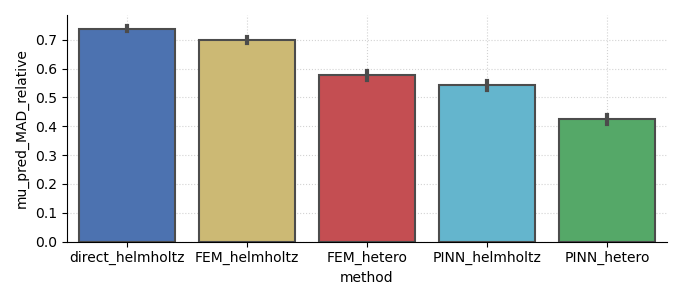

In [91]:
fig = ps.plot(
    mm[~mm.spatial_region.isin({'0.0', 'all'})],
    x='method',
    y='mu_pred_MAD_relative',
    height=3,
    width=7,
    legend=True,
    tight=True,
    plot_func=ps.results.barplot
)
for i, patch in enumerate(fig.axes[0].patches):
    plt.setp(patch, facecolor=colors[i])

<IPython.core.display.Javascript object>


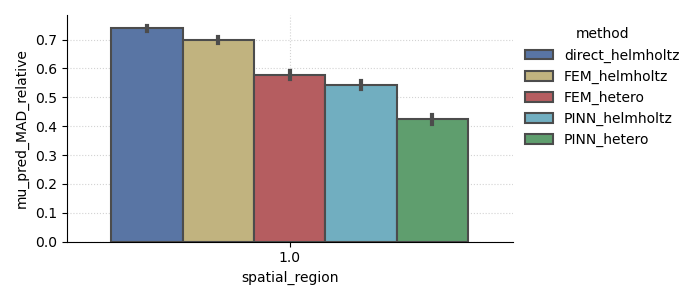

In [92]:
fig = ps.plot(
    mm[~mm.spatial_region.isin({'0.0', 'all'})],
    x='spatial_region',
    y='mu_pred_MAD_relative',
    hue='method',
    height=3,
    width=7,
    legend=True,
    tight=True,
    plot_func=ps.results.barplot
)

<IPython.core.display.Javascript object>


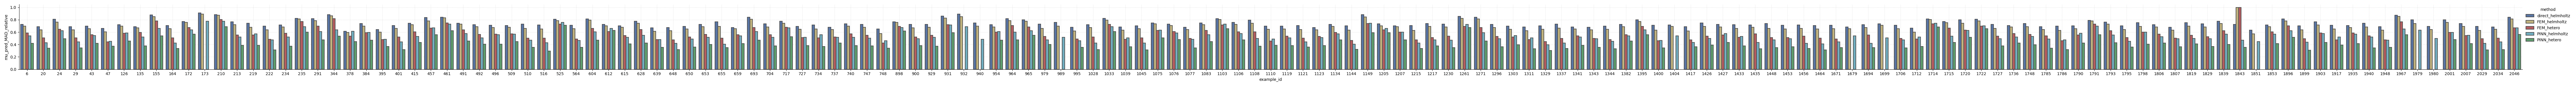

In [87]:
fig = ps.plot(
    mm[~mm.spatial_region.isin({'0.0', 'all'})],
    x='example_id',
    y='mu_pred_MAD_relative',
    hue='method',
    height=3,
    width=90,
    legend=True,
    tight=True,
    plot_func=ps.results.barplot
)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[group_name] = df[group_cols].astype(str).agg(sep.join, axis=1)



<IPython.core.display.Javascript object>


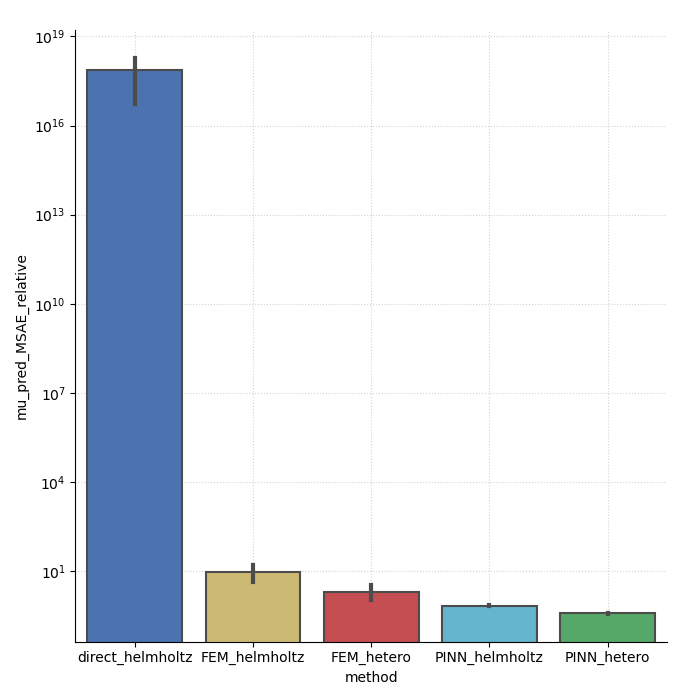

In [94]:
fig = ps.plot(
    mm[(mm.spatial_region == 'all') & (mm.spatial_frequency_bin == 'all')],
    x='method',
    y='mu_pred_MSAE_relative',
    height=7,
    width=7,
    legend=True,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_yscale('log')
for i, patch in enumerate(fig.axes[0].patches):
    plt.setp(patch, facecolor=colors[i])

<IPython.core.display.Javascript object>


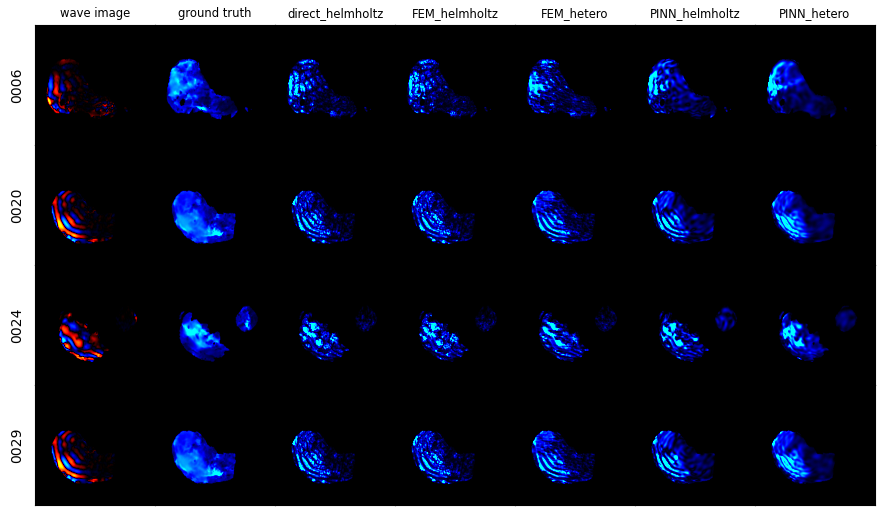

Loading ../data/NAFLD/v3/0006/wave.nc
Loading ../data/NAFLD/v3/0006/mre.nc
Loading ../data/NAFLD/v3/0006/mre_mask.nc
Loading 2022-11-26_patient_hetero2/train_patient_0006_helmholtz/train_patient_0006_helmholtz_direct.nc
Loading 2022-11-26_patient_hetero2/train_patient_0006_helmholtz/train_patient_0006_helmholtz_fem.nc
Loading 2022-11-23_patient_init/train_patient_0006_hetero/train_patient_0006_hetero_fem.nc
Loading 2022-11-26_patient_hetero2/train_patient_0006_helmholtz/train_patient_0006_helmholtz_elastogram.nc
Loading 2022-11-23_patient_init/train_patient_0006_hetero/train_patient_0006_hetero_elastogram.nc
Loading ../data/NAFLD/v3/0020/wave.nc
Loading ../data/NAFLD/v3/0020/mre.nc
Loading ../data/NAFLD/v3/0020/mre_mask.nc
Loading 2022-11-26_patient_hetero2/train_patient_0020_helmholtz/train_patient_0020_helmholtz_direct.nc
Loading 2022-11-26_patient_hetero2/train_patient_0020_helmholtz/train_patient_0020_helmholtz_fem.nc
Loading 2022-11-23_patient_init/train_patient_0020_hetero/train_

<IPython.core.display.Javascript object>


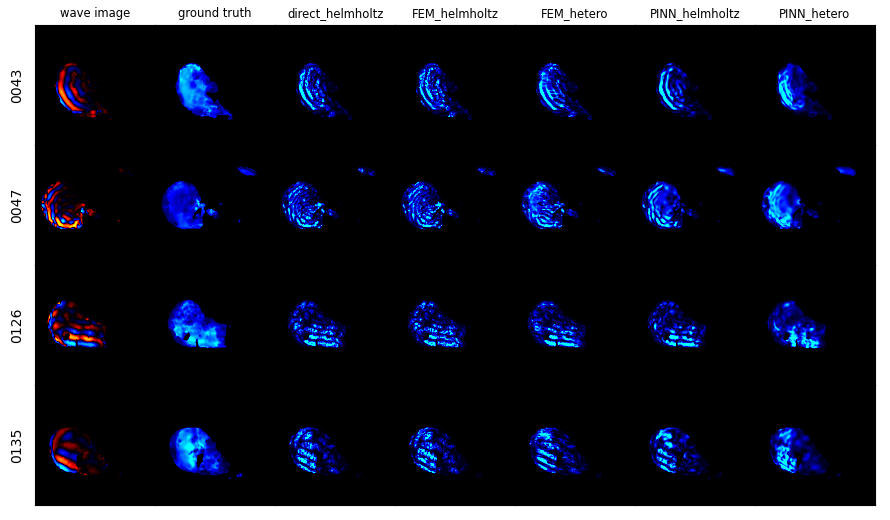

Loading ../data/NAFLD/v3/0043/wave.nc
Loading ../data/NAFLD/v3/0043/mre.nc
Loading ../data/NAFLD/v3/0043/mre_mask.nc
Loading 2022-11-26_patient_hetero2/train_patient_0043_helmholtz/train_patient_0043_helmholtz_direct.nc
Loading 2022-11-26_patient_hetero2/train_patient_0043_helmholtz/train_patient_0043_helmholtz_fem.nc
Loading 2022-11-23_patient_init/train_patient_0043_hetero/train_patient_0043_hetero_fem.nc
Loading 2022-11-26_patient_hetero2/train_patient_0043_helmholtz/train_patient_0043_helmholtz_elastogram.nc
Loading 2022-11-23_patient_init/train_patient_0043_hetero/train_patient_0043_hetero_elastogram.nc
Loading ../data/NAFLD/v3/0047/wave.nc
Loading ../data/NAFLD/v3/0047/mre.nc
Loading ../data/NAFLD/v3/0047/mre_mask.nc
Loading 2022-11-26_patient_hetero2/train_patient_0047_helmholtz/train_patient_0047_helmholtz_direct.nc
Loading 2022-11-26_patient_hetero2/train_patient_0047_helmholtz/train_patient_0047_helmholtz_fem.nc
Loading 2022-11-23_patient_init/train_patient_0047_hetero/train_

In [106]:
%autoreload
import mre_pinn

image_names = ['wave image', 'ground truth', 'direct_helmholtz', 'FEM_helmholtz', 'FEM_hetero', 'PINN_helmholtz', 'PINN_hetero']

def plot_image_grid(example_ids):
    n_rows = len(example_ids)
    n_cols = len(image_names)
    ax_width = 1.2
    ax_height = ax_width

    fig, axes, cbar_ax = mre_pinn.visual.subplot_grid(n_rows, n_cols, ax_height, ax_width, space=0, pad=(0.35,0.15,0.15,0.25))
    for row_idx, example_id in enumerate(example_ids):
        example = mre_pinn.data.MREExample.load_xarrays('../data/NAFLD/v3', example_id)
        for col_idx, image_name in enumerate(image_names):
            ax = axes[row_idx,col_idx]
            #ax.text(0.1, 0.1, f'{row_idx}, {col_idx}')
            if col_idx == 0:
                ax.set_ylabel(example_id, fontsize='medium')
            if row_idx == 0:
                ax.set_title(image_name, fontsize='small')
            ax.set_yticks([])
            ax.set_xticks([])

            if image_name == 'wave image':
                array = example.wave[...,0]
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = array.real * example.mre_mask.values[...,0]

            elif image_name == 'ground truth':
                array = example.mre[...,0]
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array) * example.mre_mask.values[...,0]

            elif image_name == 'direct_helmholtz':
                nc_file = f'2022-11-26_patient_hetero2/train_patient_{example_id}_helmholtz/train_patient_{example_id}_helmholtz_direct.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='direct_pred')[...,0]
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'FEM_helmholtz':
                nc_file = f'2022-11-26_patient_hetero2/train_patient_{example_id}_helmholtz/train_patient_{example_id}_helmholtz_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred')[...,0]
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'FEM_hetero':
                nc_file = f'2022-11-23_patient_init/train_patient_{example_id}_hetero/train_patient_{example_id}_hetero_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred')[...,0]
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'PINN_helmholtz':
                nc_file = f'2022-11-26_patient_hetero2/train_patient_{example_id}_helmholtz/train_patient_{example_id}_helmholtz_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred')[...,0]
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'PINN_hetero':
                nc_file = f'2022-11-23_patient_init/train_patient_{example_id}_hetero/train_patient_{example_id}_hetero_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred')[...,0]
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            mre_pinn.visual.imshow(ax, array, **color_kws)

plot_image_grid(['0006', '0020', '0024', '0029'])
plot_image_grid(['0043', '0047', '0126', '0135'])